In [ ]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import utils
from model01 import MLPModel01
from metrics import performance_report
import datasets

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_curve, confusion_matrix

In [21]:
n_categories = 2 # implicit in prepare_data (maybe parameterise)
lookahead = 1
window = 60
sym = 'EURSEK'

In [22]:
X_train, Y_train, prices_train, fut_return_train = datasets.load(datasets.filename('DS1', lookahead, window, sym, 2009))

X_dev, Y_dev, prices_dev, fut_return_dev = datasets.load(datasets.filename('DS1', lookahead, window, sym, 2010))
# sample 50k records from 2010 as dev set
dev_idx = np.random.choice(len(X_dev), 50000, replace=False)
X_dev, Y_dev, prices_dev, fut_return_dev = X_dev.ix[dev_idx], Y_dev.ix[dev_idx], prices_dev.ix[dev_idx], fut_return_dev.ix[dev_idx]

X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename('DS1', lookahead, window, sym, 2011))

In [23]:
print("train", X_train.shape)
print("dev", X_dev.shape)
print("test", X_test.shape)
n_features = X_train.shape[1]
print ("n_features:", n_features)

train (186501, 243)
dev (50000, 243)
test (251793, 243)
n_features: 243


In [10]:
# from sklearn.linear_model import SGDClassifier
# lin_model = SGDClassifier(loss='hinge', penalty='l2', n_iter=200, n_jobs=10)
# lin_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lin_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lin_model.predict(X_test), average='weighted'))

In [11]:
# from sklearn.linear_model import LogisticRegression
# lr_model = LogisticRegression(n_jobs=10)
# lr_model.fit(X_train.as_matrix(), Y_train)

# print( "train f1", f1_score(Y_train, lr_model.predict(X_train), average='weighted') )
# print( "test f1", f1_score(Y_test, lr_model.predict(X_test), average='weighted'))

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=5, n_jobs=12)
rf_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, rf_model.predict(X_train), average='weighted') )
print( "dev f1", f1_score(Y_dev, rf_model.predict(X_dev), average='weighted'))
print( "test f1", f1_score(Y_test, rf_model.predict(X_test), average='weighted'))

train f1 0.500486377942
dev f1 0.504400138292
test f1 0.483528064668


In [24]:
layer_widths = [100,100,100]
dropout = 0.5

In [25]:
model = MLPModel01(lookahead, n_features, n_categories, layer_widths, dropout)
print (model.summary())

compilation took: 0.5 seconds
Model id:  MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 100)           24400       dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 100)           0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 100)           10100       dropout_4[0][0]                  
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 100)           0           dense_6[0][0]               

In [26]:
max_epochs = 200
hist = model.fit(
    X_train.as_matrix(), Y_train, 
    validation_data=(X_dev.as_matrix(),Y_dev), 
    max_epochs=max_epochs,
    es_patience=25, 
    es_min_delta=1e-5,
    batch_size=1024*50)

Epoch 0, train_loss: 1.1889 val_loss 0.7222  train_accuracy 0.5012 val_accuracy 0.4868  train_f1 0.5219 val_f1 0.2464
Epoch 1, train_loss: 0.9348 val_loss 0.6988  train_accuracy 0.5000 val_accuracy 0.5014  train_f1 0.4837 val_f1 0.4509
Epoch 2, train_loss: 0.8235 val_loss 0.6953  train_accuracy 0.5017 val_accuracy 0.5026  train_f1 0.5096 val_f1 0.4889
Epoch 3, train_loss: 0.7785 val_loss 0.6952  train_accuracy 0.5017 val_accuracy 0.4964  train_f1 0.5175 val_f1 0.4243
Epoch 4, train_loss: 0.7484 val_loss 0.6945  train_accuracy 0.5028 val_accuracy 0.4954  train_f1 0.5165 val_f1 0.4014
saved to  ./output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-005-0.6945.hdf5
Epoch 5, train_loss: 0.7337 val_loss 0.6941  train_accuracy 0.5017 val_accuracy 0.4956  train_f1 0.5108 val_f1 0.4052
Epoch 6, train_loss: 0.7238 val_loss 0.6938  train_accuracy 0.5020 val_accuracy 0.4955  train_f1 0.5081 val_f1 0.4091
Epoch 7, train_loss: 0.7160 val_loss 0.6937  train_accuracy 0.5031 val_accuracy 0.4

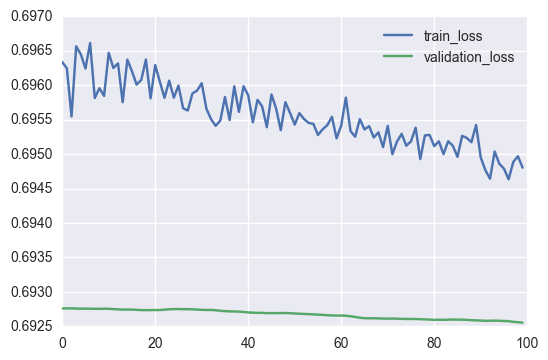

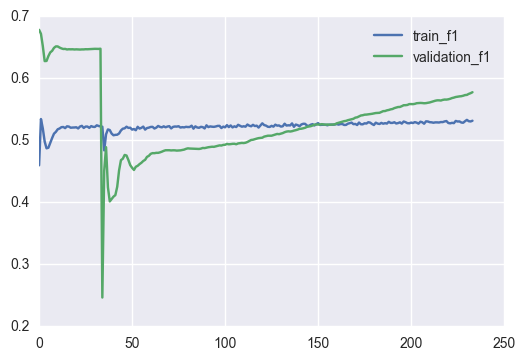

In [27]:
plt.plot(model.progress_callback.train_losses[-100:], label='train_loss')
plt.plot(model.progress_callback.validation_losses[-100:], label='validation_loss')
plt.legend()
plt.show()
plt.plot(model.progress_callback.train_f1s, label='train_f1')
plt.plot(model.progress_callback.validation_f1s, label='validation_f1')

plt.legend();

In [28]:
Y_train_pred = model.predict(X_train.as_matrix(), batch_size=1024)
Y_train_pred_class = utils.prediction_to_category2(Y_train_pred)

Y_dev_pred = model.predict(X_dev.as_matrix(), batch_size=1024)
Y_dev_pred_class = utils.prediction_to_category2(Y_dev_pred)

Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)

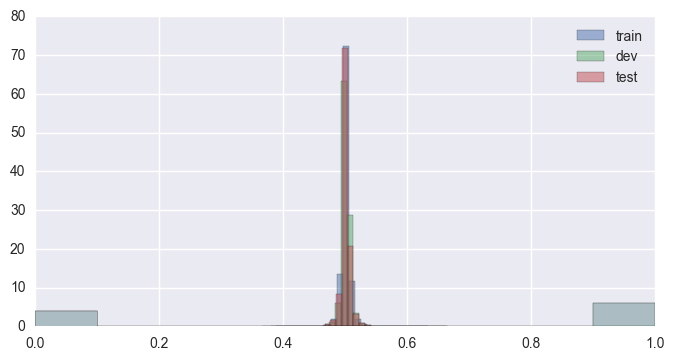

In [30]:
plt.figure(figsize=(8,4))
plt.hist(Y_train_pred, alpha=0.5, bins=30, normed=True, label='train')
plt.hist(Y_dev_pred, alpha=0.5, bins=30, normed=True, label='dev')
plt.hist(Y_test_pred, alpha=0.5, bins=30, normed=True, label='test')

plt.hist(Y_train_pred_class, alpha=0.3, normed=True)
plt.hist(Y_dev_pred_class, alpha=0.3, normed=True)
plt.hist(Y_test_pred_class, alpha=0.3, normed=True)
plt.legend()

------------------------------------------------------
train
f1-score: 0.511
             precision    recall  f1-score   support

          0       0.51      0.41      0.46     92290
          1       0.52      0.62      0.56     94211

avg / total       0.52      0.52      0.51    186501

------------------------------------------------------
dev
f1-score: 0.518
             precision    recall  f1-score   support

          0       0.50      0.41      0.45     23726
          1       0.54      0.62      0.58     26274

avg / total       0.52      0.52      0.52     50000

------------------------------------------------------
test
f1-score: 0.506
             precision    recall  f1-score   support

          0       0.51      0.40      0.45    123969
          1       0.52      0.62      0.56    127824

avg / total       0.51      0.51      0.51    251793



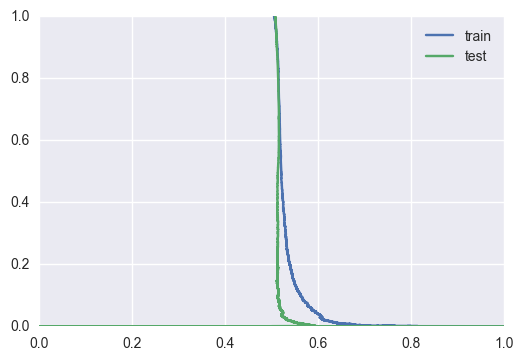

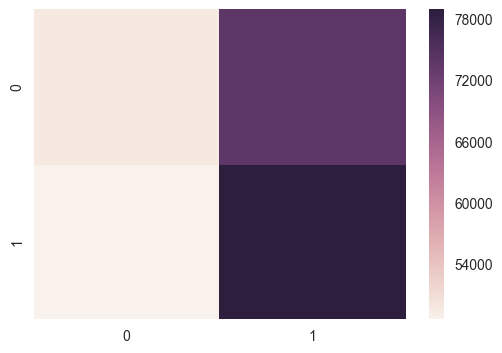

In [31]:
performance_report("train", prices_train, lookahead, Y_train, Y_train_pred_class)
performance_report("dev",  prices_dev,  lookahead, Y_dev, Y_dev_pred_class)
performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)

train_curve = precision_recall_curve(Y_train, Y_train_pred)
test_curve = precision_recall_curve(Y_test, Y_test_pred)

plt.plot(train_curve[0], train_curve[1], label='train')
plt.plot(test_curve[0], test_curve[1], label='test')
plt.legend()
plt.show()
sns.heatmap(confusion_matrix(Y_test, Y_test_pred_class))

In [ ]:
~Y_test_pred_class[:,0]

#(fut_return_test.ix[~Y_test_pred_class[:,0]]+1).cumprod().plot()

dropout = 0  , lookahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 1     | 1         |  100   | .57   | .58  |
| 1     | 100       |  100   | .58   | .59  |
| 1     | 100       |  500   | .57   | .59  |
| 1     | 100 x 100 |  100 | .58   | .59  |
| 10    | 1         |  100 |  .57  | .59  |
| 10    | 10        |  100 |  .57  | .58  |
| 10    | 100       |  100 |  .58 | .58   |
| 10    | 100 x 100 |  100 |  .60 | .58   |
| 10    | 100 x 100 x 100 |  100 |  .62 | .57   |
| 10    | 100 x 100 x 100 x 100 |  100 |  .63 | .56   |
| 20    | 1 |  100 |  .56 | .58  |
| 20    | 100 |  100 | .58  | .58  |
| 40    | 100 |  500 x 500 x 500 | .60  | .61  |

Dropout = 0.1, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .60  | .58  |
| 10    | 100 x 100 x 100 x 100 |  200 | .62  | .58  |


Dropout = 0.2, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .59 | .59  |
| 10    | 100 x 100 x 100 x 100 |  200 | .60 | .58  |

Dropout = 0.5, lookeahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 60    | 500 x 500 x 500 x 500 |  200 | .64 | .62|
| 60    | 100 x 100 x 100 x 100 |  200 | .64 | .65




- .681 / .57 100^3 / LA:1, W:60
- .679 / .569 100^4


In [ ]:
print( len(Y_test) )
print( len(Y_test_pred_class) )
print( len(prices_test))
print( len(utils.future_return(prices_test, 1) ))

In [ ]:
i_s = []
mean_rets = []
for i in range(1,5000,10):
    test_returns = utils.future_return(prices_test, i).fillna(0).values
    test_returns = test_returns - test_returns.mean()

    idx = np.zeros(len(test_returns))
    idx[Y_test_pred_class[:,0] == 0] = -1
    idx[Y_test_pred_class[:,0] == 1] = 1

    mean_ret = (test_returns * idx).mean() * 1e4
    mean_rets.append(mean_ret)
    i_s.append(i/60) #*24))
plt.plot(i_s, mean_rets,'.-')

In [ ]:
prices_test.plot()

In [ ]:
n_trade = 1000


In [ ]:
18000 / (60*24)

------------------------------------------------------
test
f1-score: 0.500
             precision    recall  f1-score   support

          0       0.50      0.39      0.44    153535
          1       0.51      0.62      0.56    155849

avg / total       0.51      0.51      0.50    309384



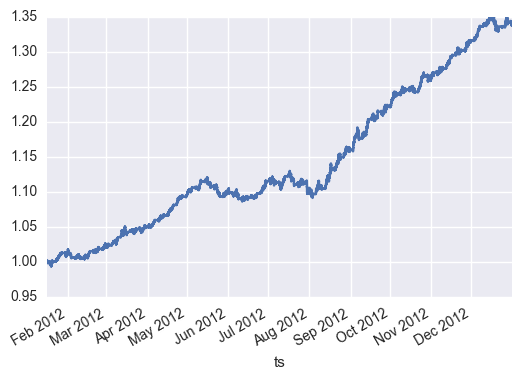

In [74]:

# load test dataset
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename('DS1', lookahead, window, sym, 2012))
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = utils.prediction_to_category2(Y_test_pred)
performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred_class)
(fut_return_test.ix[Y_test_pred_class[:,0]]+1).cumprod().plot()

# TODO: demean fut_return..